<h1>NBA Shot predictor</h1>

### Motivation
The Goal of this project is to see if we can use Machine Learning to predict where NBA players will shoot next

In [5]:
#Set up the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


In [56]:
#Set up the dataframe
df = pd.read_csv('data/NBA Shot Locations 1997 - 2020.csv')
df.head(3)

,Game ID,Game Event ID,Player ID,Player Name,Team ID,Team Name,Period,Minutes Remaining,Seconds Remaining,Action Type,...,Shot Zone Area,Shot Zone Range,Shot Distance,X Location,Y Location,Shot Made Flag,Game Date,Home Team,Away Team,Season Type
0,29700427,389,100,Tim Legler,1610612764,Washington Wizards,4,11,22,Jump Shot,...,Right Side(R),8-16 ft.,15,117,109,1,19980102,WAS,IND,Regular Season
1,29700427,406,100,Tim Legler,1610612764,Washington Wizards,4,9,36,Jump Shot,...,Right Side(R),8-16 ft.,14,143,25,0,19980102,WAS,IND,Regular Season
2,29700427,475,100,Tim Legler,1610612764,Washington Wizards,4,3,7,Jump Shot,...,Left Side(L),8-16 ft.,10,-87,55,0,19980102,WAS,IND,Regular Season


Set up a test df to run quick models on. Will use after finishing EDA

In [7]:
#Test Data Frame will be LeBron James, Raptors Player, PG
test_df=df[df['Player Name'] == 'LeBron James']
test_df.head(3)

,Game ID,Game Event ID,Player ID,Player Name,Team ID,Team Name,Period,Minutes Remaining,Seconds Remaining,Action Type,...,Shot Zone Area,Shot Zone Range,Shot Distance,X Location,Y Location,Shot Made Flag,Game Date,Home Team,Away Team,Season Type
1194060,20300014,20,2544,LeBron James,1610612739,Cleveland Cavaliers,1,8,56,Jump Shot,...,Right Side(R),8-16 ft.,15,158,0,1,20031029,SAC,CLE,Regular Season
1194061,20300014,28,2544,LeBron James,1610612739,Cleveland Cavaliers,1,7,44,Jump Shot,...,Left Side(L),8-16 ft.,13,-131,2,1,20031029,SAC,CLE,Regular Season
1194062,20300014,35,2544,LeBron James,1610612739,Cleveland Cavaliers,1,7,1,Fadeaway Jump Shot,...,Right Side(R),16-24 ft.,16,163,5,1,20031029,SAC,CLE,Regular Season


## EDA

In [55]:
#Total Amount of Players
df.groupby(['Player ID']).sum().shape

(2152, 11)

2152 players in this data frame 

In [6]:
# Count of each shot
df['Shot Zone Area'].value_counts()

Center(C)                2494850
Left Side(L)              614701
Right Side(R)             565487
Right Side Center(RC)     526949
Left Side Center(LC)      515926
Back Court(BC)             11599
Name: Shot Zone Area, dtype: int64

There is a huge class imbalance over here, we can see that most of the shots come from Center. Also it seems Back Court is a really small amount that is probably causing noise.

In [9]:
#As a precentage
df['Shot Zone Area'].value_counts(normalize=True)

Center(C)                0.527507
Left Side(L)             0.129971
Right Side(R)            0.119566
Right Side Center(RC)    0.111417
Left Side Center(LC)     0.109087
Back Court(BC)           0.002452
Name: Shot Zone Area, dtype: float64

More than 50% of the shots come from the center, with left and right side taking just above 20% almost evenly

In [10]:
# Shot zone basic
df['Shot Zone Basic'].value_counts()

Restricted Area          1505921
Mid-Range                1417625
Above the Break 3         828349
In The Paint (Non-RA)     683748
Left Corner 3             147043
Right Corner 3            137365
Backcourt                   9461
Name: Shot Zone Basic, dtype: int64

In [11]:
# SHot zone basic as a percentage
df['Shot Zone Basic'].value_counts(normalize=True)


Restricted Area          0.318409
Mid-Range                0.299740
Above the Break 3        0.175145
In The Paint (Non-RA)    0.144571
Left Corner 3            0.031091
Right Corner 3           0.029044
Backcourt                0.002000
Name: Shot Zone Basic, dtype: float64

More than 30% of the shots came from the Restricted Area, these are typical shots that are layups or dunks.<br>
We will probably end up roll up 'Shot Zone Area' so the classes are easier to make predictions easier

### Now lets take a look at some individual players stats

In [16]:
df.groupby('Player Name')['Shot Made Flag'].count().sort_values(ascending=False).head(10)

Player Name
Kobe Bryant        30220
LeBron James       29658
Dirk Nowitzki      26376
Tim Duncan         24221
Vince Carter       22677
Carmelo Anthony    22526
Paul Pierce        21877
Kevin Garnett      21472
Dwyane Wade        20677
Allen Iverson      20284
Name: Shot Made Flag, dtype: int64

The late Kobe Bryant, has taken the most shots, followed by LeBron and Dirk.
Now lets see who has made the most shots

In [8]:
df.groupby('Player Name')['Shot Made Flag'].sum().sort_values(ascending=False).head(10)

Player Name
LeBron James       14881
Kobe Bryant        13534
Dirk Nowitzki      12389
Tim Duncan         12238
Kevin Garnett      10630
Carmelo Anthony    10042
Dwyane Wade         9904
Vince Carter        9849
Paul Pierce         9689
Tony Parker         9390
Name: Shot Made Flag, dtype: int64

Unsuprisingly, the top 3 are the same, however Lebron has made more shots than Kobe, almost 1500 more shots despite taking 300 less. Lets check the averages for the best shooters

In [159]:
#Lets get a df of shots players have  taken split by taken or not
shot=df.groupby(['Player Name','Shot Made Flag']).count()
shot

Game ID  Game Event ID  Player ID  Team ID  \
Player Name        Shot Made Flag                                               
A.C. Green         0                   889            889        889      889   
                   1                   705            705        705      705   
A.J. Bramlett      0                    17             17         17       17   
                   1                     4              4          4        4   
A.J. Guyton        0                   274            274        274      274   
...                                    ...            ...        ...      ...   
Zoran Planinic     1                   197            197        197      197   
Zydrunas Ilgauskas 0                  4994           4994       4994     4994   
                   1                  4534           4534       4534     4534   
Zylan Cheatham     0                     3              3          3        3   
                   1                     2              2          2        2   

                                   Team Name  Period  Minutes Remaining  \
Player Name        Shot Made Flag                                         
A.C. Green         0                     889     889                889   
                   1                     705     705                705   
A.J. Bramlett      0                      17      17                 17   
                   1                       4       4                  4   
A.J. Guyton        0                     274     274                274   
...                                      ...     ...                ...   
Zoran Planinic     1                     197     197                197   
Zydrunas Ilgauskas 0                    4994    4994               4994   
                   1                    4534    4534               4534   
Zylan Cheatham     0                       3       3                  3   
                   1                       2       2                  2   

                                   Seconds Remaining  Action Type  Shot Type  \
Player Name        Shot Made Flag                                              
A.C. Green         0                             889          889        889   
                   1                             705          705        705   
A.J. Bramlett      0                              17           17         17   
                   1                               4            4          4   
A.J. Guyton        0                             274          274        274   
...                                              ...          ...        ...   
Zoran Planinic     1                             197          197        197   
Zydrunas Ilgauskas 0                            4994         4994       4994   
                   1                            4534         4534       4534   
Zylan Cheatham     0                               3            3          3   
                   1                               2            2          2   

                                   Shot Zone Basic  Shot Zone Area  \
Player Name        Shot Made Flag                                    
A.C. Green         0                           889             889   
                   1                           705             705   
A.J. Bramlett      0                            17              17   
                   1                             4               4   
A.J. Guyton        0                           274             274   
...                                            ...             ...   
Zoran Planinic     1                           197             197   
Zydrunas Ilgauskas 0                          4994            4994   
                   1                          4534            4534   
Zylan Cheatham     0                             3               3   
                   1                             2               2   

                                   Shot Zone Range  S

In [11]:
#Only get those numbers
shot['Game ID']

Player Name         Shot Made Flag
A.C. Green          0                  889
                    1                  705
A.J. Bramlett       0                   17
                    1                    4
A.J. Guyton         0                  274
                                      ... 
Zoran Planinic      1                  197
Zydrunas Ilgauskas  0                 4994
                    1                 4534
Zylan Cheatham      0                    3
                    1                    2
Name: Game ID, Length: 4236, dtype: int64

In [160]:
#Lets get shooting percetages
shotpt= df.groupby(['Player Name'])
shotpt


In [161]:
#get it as a percentage
x=shotpt['Shot Made Flag'].value_counts(normalize=True)
x

Player Name         Shot Made Flag
A.C. Green          0                 0.557716
                    1                 0.442284
A.J. Bramlett       0                 0.809524
                    1                 0.190476
A.J. Guyton         0                 0.624146
                                        ...   
Zoran Planinic      1                 0.402863
Zydrunas Ilgauskas  0                 0.524139
                    1                 0.475861
Zylan Cheatham      0                 0.600000
                    1                 0.400000
Name: Shot Made Flag, Length: 4236, dtype: float64

In [162]:
#Add the series into a column
shot['Shooting Pct'] = x
shot

Game ID  Game Event ID  Player ID  Team ID  \
Player Name        Shot Made Flag                                               
A.C. Green         0                   889            889        889      889   
                   1                   705            705        705      705   
A.J. Bramlett      0                    17             17         17       17   
                   1                     4              4          4        4   
A.J. Guyton        0                   274            274        274      274   
...                                    ...            ...        ...      ...   
Zoran Planinic     1                   197            197        197      197   
Zydrunas Ilgauskas 0                  4994           4994       4994     4994   
                   1                  4534           4534       4534     4534   
Zylan Cheatham     0                     3              3          3        3   
                   1                     2              2          2        2   

                                   Team Name  Period  Minutes Remaining  \
Player Name        Shot Made Flag                                         
A.C. Green         0                     889     889                889   
                   1                     705     705                705   
A.J. Bramlett      0                      17      17                 17   
                   1                       4       4                  4   
A.J. Guyton        0                     274     274                274   
...                                      ...     ...                ...   
Zoran Planinic     1                     197     197                197   
Zydrunas Ilgauskas 0                    4994    4994               4994   
                   1                    4534    4534               4534   
Zylan Cheatham     0                       3       3                  3   
                   1                       2       2                  2   

                                   Seconds Remaining  Action Type  Shot Type  \
Player Name        Shot Made Flag                                              
A.C. Green         0                             889          889        889   
                   1                             705          705        705   
A.J. Bramlett      0                              17           17         17   
                   1                               4            4          4   
A.J. Guyton        0                             274          274        274   
...                                              ...          ...        ...   
Zoran Planinic     1                             197          197        197   
Zydrunas Ilgauskas 0                            4994         4994       4994   
                   1                            4534         4534       4534   
Zylan Cheatham     0                               3            3          3   
                   1                               2            2          2   

                                   ...  Shot Zone Area  Shot Zone Range  \
Player Name        Shot Made Flag  ...                                    
A.C. Green         0               ...             889              889   
                   1               ...             705              705   
A.J. Bramlett      0               ...              17               17   
                   1               ...               4                4   
A.J. Guyton        0               ...             274              274   
...                                ...             ...              ...   
Zoran Planinic     1               ...             197              197   
Zydrunas Ilgauskas 0               ...            4994             4994   
                   1               ...            4534             4534   
Zylan Cheatham     0               ...               3                3   
                   1               ...               2          

In [163]:
#Lets Reset the index
shot.reset_index(inplace=True)

In [164]:
#Lets take all the made shots
shot=shot[shot['Shot Made Flag']==1]

In [165]:
#Check
shot

,Player Name,Shot Made Flag,Game ID,Game Event ID,Player ID,Team ID,Team Name,Period,Minutes Remaining,Seconds Remaining,...,Shot Zone Area,Shot Zone Range,Shot Distance,X Location,Y Location,Game Date,Home Team,Away Team,Season Type,Shooting Pct
1,A.C. Green,1,705,705,705,705,705,705,705,705,...,705,705,705,705,705,705,705,705,705,0.442284
3,A.J. Bramlett,1,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,0.190476
5,A.J. Guyton,1,165,165,165,165,165,165,165,165,...,165,165,165,165,165,165,165,165,165,0.375854
7,AJ Hammons,1,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,0.404762
9,AJ Price,1,563,563,563,563,563,563,563,563,...,563,563,563,563,563,563,563,563,563,0.380149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,Zion Williamson,1,172,172,172,172,172,172,172,172,...,172,172,172,172,172,172,172,172,172,0.589041
4229,Zoran Dragic,1,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,0.366667
4231,Zoran Planinic,1,197,197,197,197,197,197,197,197,...,197,197,197,197,197,197,197,197,197,0.402863
4233,Zydrunas Ilgauskas,1,4534,4534,4534,4534,4534,4534,4534,4534,...,4534,4534,4534,4534,4534,4534,4534,4534,4534,0.475861


In [167]:
#There are alot of players with too little shots, lets just take players who have made more than 5000 shots
shot=shot[shot['Game ID']>=5000]

In [19]:
#Lets reduce the columns
shot=shot[['Player Name','Shooting Pct','Game ID']]

In [20]:
#Change the name of Game ID
shot=shot.rename(columns={"Game ID": "Shots Made"})
shot

,Player Name,Shooting Pct,Shots Made
53,Al Harrington,0.441864,5176
55,Al Horford,0.517475,5641
57,Al Jefferson,0.499007,6282
111,Allen Iverson,0.423832,8597
131,Amar'e Stoudemire,0.534766,6422
...,...,...,...
3850,Tim Duncan,0.505264,12238
3917,Tony Parker,0.485799,9390
3933,Tracy McGrady,0.434724,7106
4071,Vince Carter,0.434317,9849


In [21]:
#Lets take a look at the top 10
shot.sort_values(by='Shooting Pct',ascending=False).head(10)

,Player Name,Shooting Pct,Shots Made
1244,Dwight Howard,0.586064,7351
3627,Shaquille O'Neal,0.580606,9173
131,Amar'e Stoudemire,0.534766,6422
55,Al Horford,0.517475,5641
552,Carlos Boozer,0.517338,6430
3189,Pau Gasol,0.507358,8792
3850,Tim Duncan,0.505264,12238
2536,LeBron James,0.501753,14881
1311,Elton Brand,0.500920,6805
57,Al Jefferson,0.499007,6282


This is quite interesting, we don't have the data for their positions or size. However, I know that these are all big men. Every player here apart from LeBron James plays either Center or Power Forward, and every player on this list is taller than or is 6 ft 9. This is suprising because you would think shooters would have the best shooting percentage, however it shows thats big men in the NBA are able to convert possesions at a very effecient rate.  

## Lets make some Graphs 

### Shots Taken

In [57]:
#Take the top 10 players by shots taken
Shot_taken=df.groupby('Player Name')['Shot Made Flag'].count().sort_values(ascending=False).head(10)

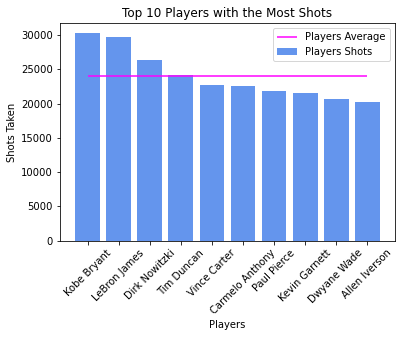

In [58]:
#Plotting
plt.bar(Shot_taken.index,Shot_taken,color='cornflowerblue',label='Players Shots')
plt.hlines(y=Shot_taken.mean(axis=0),xmin=0,xmax=9,colors='fuchsia',label='Players Average')
plt.ylabel('Shots Taken')
plt.xlabel('Players')
plt.title('Top 10 Players with the Most Shots')
plt.xticks(rotation=45)
plt.legend()
plt;


### Shots Made

In [24]:
#Make a shots made
Shot_Made=df.groupby('Player Name')['Shot Made Flag'].sum().sort_values(ascending=False).head(10)

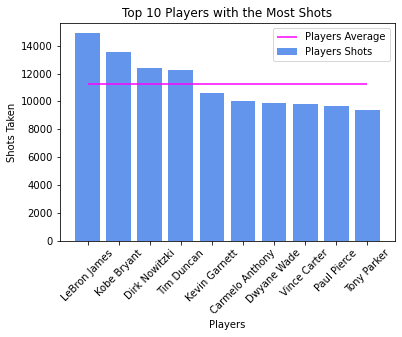

In [25]:
#Plotting
plt.bar(Shot_Made.index,Shot_Made,color='cornflowerblue',label='Players Shots')
plt.hlines(y=Shot_Made.mean(axis=0),xmin=0,xmax=9,colors='fuchsia',label='Players Average')
plt.ylabel('Shots Taken')
plt.xlabel('Players')
plt.title('Top 10 Players with the Most Shots')
plt.xticks(rotation=45)
plt.legend()
plt;

### Shooting Percentage

In [26]:
#The shooting average
Shot_avg=shot.sort_values(by='Shooting Pct',ascending=False).head(10)

In [27]:
Shot_avg

,Player Name,Shooting Pct,Shots Made
1244,Dwight Howard,0.586064,7351
3627,Shaquille O'Neal,0.580606,9173
131,Amar'e Stoudemire,0.534766,6422
55,Al Horford,0.517475,5641
552,Carlos Boozer,0.517338,6430
3189,Pau Gasol,0.507358,8792
3850,Tim Duncan,0.505264,12238
2536,LeBron James,0.501753,14881
1311,Elton Brand,0.500920,6805
57,Al Jefferson,0.499007,6282


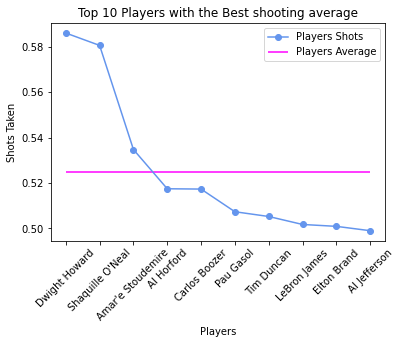

In [28]:
#Plotting
plt.plot(Shot_avg['Player Name'],Shot_avg['Shooting Pct'],color='cornflowerblue',label='Players Shots',marker='o')
plt.hlines(y=Shot_avg['Shooting Pct'].mean(axis=0),xmin=0,xmax=9,colors='fuchsia',label='Players Average')
plt.ylabel('Shots Taken')
plt.xlabel('Players')
plt.title('Top 10 Players with the Best shooting average')
plt.xticks(rotation=45)
plt.legend()
plt;

## Initial Player Regression

Lets take a look at the Lebrons James data

In [60]:
#Double check
test_df.shape

(29658, 22)

We have 29,658 shots. Lets first drop the columns that arnt important

In [59]:
#take a look at the columns
test_df.columns

Index(['Game ID', 'Game Event ID', 'Player ID', 'Player Name', 'Team ID',
       'Team Name', 'Period', 'Minutes Remaining', 'Seconds Remaining',
       'Action Type', 'Shot Type', 'Shot Zone Basic', 'Shot Zone Area',
       'Shot Zone Range', 'Shot Distance', 'X Location', 'Y Location',
       'Shot Made Flag', 'Game Date', 'Home Team', 'Away Team', 'Season Type'],
      dtype='object')

In [61]:
#Check the types
test_df.dtypes

Game ID               int64
Game Event ID         int64
Player ID             int64
Player Name          object
Team ID               int64
Team Name            object
Period                int64
Minutes Remaining     int64
Seconds Remaining     int64
Action Type          object
Shot Type            object
Shot Zone Basic      object
Shot Zone Area       object
Shot Zone Range      object
Shot Distance         int64
X Location            int64
Y Location            int64
Shot Made Flag        int64
Game Date             int64
Home Team            object
Away Team            object
Season Type          object
dtype: object

Lets first just run the model and see how it goes

In [8]:
#Drop unwanted columns
DT_df= test_df.drop(['Player Name','Game Event ID', 'Team Name','X Location', 'Y Location', 'Home Team','Away Team','Season Type' ],axis=1)

In [9]:
#Double check
DT_df.dtypes

Game ID               int64
Player ID             int64
Team ID               int64
Period                int64
Minutes Remaining     int64
Seconds Remaining     int64
Action Type          object
Shot Type            object
Shot Zone Basic      object
Shot Zone Area       object
Shot Zone Range      object
Shot Distance         int64
Shot Made Flag        int64
Game Date             int64
dtype: object

In [10]:
#Quickly check for class imbalance
DT_df['Shot Zone Area'].value_counts()

Center(C)                16478
Left Side Center(LC)      3970
Left Side(L)              3520
Right Side Center(RC)     3020
Right Side(R)             2618
Back Court(BC)              52
Name: Shot Zone Area, dtype: int64

## Decision Point - Class imbalance
There is alot of class imbalance, its probably best to roll it up and drop back court. HOWEVER, we will first just run the following examples without rolling it up and then roll them up and see the difference.

### Setting up data before hand.

Since we will be running many models it is best to preprocess our data. We will be blowing out columns and then scaling the data. 

### Blowing out

In [75]:
#get dummies
idka=pd.get_dummies(DT_df['Action Type'])
idkb=pd.get_dummies(DT_df['Shot Type'])
idkc=pd.get_dummies(DT_df['Shot Zone Basic'])
idkd=pd.get_dummies(DT_df['Shot Zone Range'])

In [76]:
#concat the df
idk = pd.concat([DT_df, idka, idkb, idkc, idkd], axis=1, sort=False)

In [77]:
#drop uesless Columns
idk=idk.drop(['Action Type', 'Shot Type', 'Shot Zone Basic', 'Shot Zone Range'],axis=1)
#Check
idk.head()

,Game ID,Player ID,Team ID,Period,Minutes Remaining,Seconds Remaining,Shot Zone Area,Shot Distance,Shot Made Flag,Game Date,...,In The Paint (Non-RA),Left Corner 3,Mid-Range,Restricted Area,Right Corner 3,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1194060,20300014,2544,1610612739,1,8,56,Right Side(R),15,1,20031029,...,0,0,1,0,0,0,0,1,0,0
1194061,20300014,2544,1610612739,1,7,44,Left Side(L),13,1,20031029,...,0,0,1,0,0,0,0,1,0,0
1194062,20300014,2544,1610612739,1,7,1,Right Side(R),16,1,20031029,...,0,0,1,0,0,1,0,0,0,0
1194063,20300014,2544,1610612739,1,6,29,Left Side(L),14,0,20031029,...,0,0,1,0,0,0,0,1,0,0
1194064,20300014,2544,1610612739,1,4,48,Center(C),5,1,20031029,...,1,0,0,0,0,0,0,0,0,1


### Scaling
So for preprocessing HERE we will only be doing the min max scaler. This is because the data is not normally distributed 

In [78]:
#Split first
from sklearn.model_selection import train_test_split
X = idk.drop(['Shot Zone Area'],axis=1)
y = idk['Shot Zone Area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [79]:
#Scaler
from sklearn.preprocessing import MinMaxScaler

my_minmax_scaler = MinMaxScaler()

my_minmax_scaler = my_minmax_scaler.fit(X_train)

X_train = my_minmax_scaler.transform(X_train)

X_test = my_minmax_scaler.transform(X_test)



### Decision Tree 

100%|██████████| 9/9 [00:00<00:00,  9.56it/s]


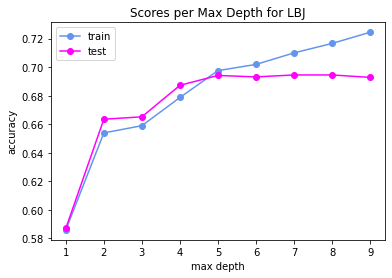

The best model has Max Depth =  7
Took  1.3  Seconds to Run


In [98]:
#Import DTC 
from sklearn.tree import DecisionTreeClassifier

#Lets also time it 
start = time.time()

# Create lists to hold our accuracies
train_accs = []
test_accs = []

depth_range = range(1, 10)

for d in tqdm(depth_range):
    
    # instantiate a tree & fit it
    my_tree = DecisionTreeClassifier(max_depth=d)
    my_tree.fit(X_train, y_train)
    
    # evaluate on train & test sets
    train_accs.append(my_tree.score(X_train, y_train))
    test_accs.append(my_tree.score(X_test, y_test))

# plot the results
plt.figure()
plt.plot(depth_range,train_accs, c='cornflowerblue', label='train', marker="o")
plt.plot(depth_range,test_accs, c='fuchsia', label='test', marker="o")
plt.title('Scores per Max Depth for LBJ')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.xticks(depth_range)
plt.legend()
plt.show()

#Catch the ArgMax
which_max = np.array(test_accs).argmax()


print("The best model has Max Depth = ",depth_range[which_max])

end = time.time()
print("Took ",round((end - start),1)," Seconds to Run")

Over here we can see that Max Depth 5 is the best as those are the closest, lets print the results

These are pretty good results, and ran exceptionally well

In [100]:
# instantiate a tree & fit it
my_tree = DecisionTreeClassifier(max_depth=depth_range[which_max])
my_tree.fit(X_train, y_train)

# evaluate on train & test sets
print(f'Train Score for Decision Tree = {round(my_tree.score(X_train, y_train),3)}')
print(f'Test Score for Decision Tree = {round(my_tree.score(X_test, y_test),3)}')

Train Score for Decision Tree = 0.71
Test Score for Decision Tree = 0.695


### Logistical Regression

100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


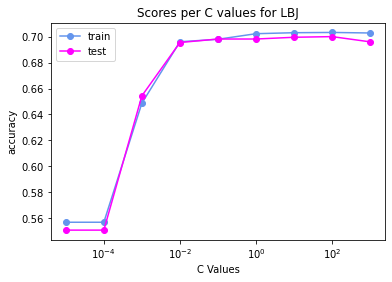

The best model has the C Value =  100
Took  12.1  Seconds to Run


In [103]:
#Import log Reg
from sklearn.linear_model import LogisticRegression

start = time.time()
# Create lists to hold our accuracies
train_acc = []
test_acc = []

# The C_values to try
C_values = [.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]



# Loop through the C values 
for C in tqdm(C_values):

    # Instantiate the model
    log_reg = LogisticRegression(C=C,max_iter=100,solver='lbfgs')

    # Fit the model 
    log_reg.fit(X_train,y_train)

    # Score the model 
    train_acc.append(log_reg.score(X_train,y_train))
    test_acc.append(log_reg.score(X_test,y_test))

# plot the results
plt.figure()
plt.plot(C_values,train_acc, c='cornflowerblue', label='train', marker="o")
plt.plot(C_values,test_acc, c='fuchsia', label='test', marker="o")
plt.title('Scores per C values for LBJ')
plt.xlabel('C Values')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend()
plt.show()

#Catch the ArgMax
which_max = np.array(test_acc).argmax()


print("The best model has the C Value = ",C_values[which_max])

end = time.time()
print("Took ",round((end - start),1)," Seconds to Run")

Looks like the best score is actually C=100

This is just slughtly better than the DT Model but almost the same

In [104]:
# Instantiate the model
log_reg = LogisticRegression(C=C_values[which_max],max_iter=100,solver='lbfgs')

# Fit the model 
log_reg.fit(X_train,y_train)

# evaluate on train & test sets
print(f'Train Score for Logistical Regression = {round(log_reg.score(X_train, y_train),3)}')
print(f'Test Score for Logistical Regression = {round(log_reg.score(X_test, y_test),3)}')

Train Score for Logistical Regression = 0.703
Test Score for Logistical Regression = 0.7


### SVM 

100%|██████████| 7/7 [01:10<00:00, 10.09s/it]


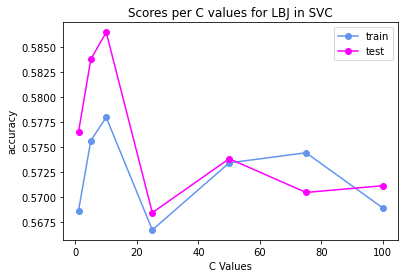

The best model has the C Value =  10
Took  71.0  Seconds to Run


In [106]:
#import SVC
from sklearn.svm import SVC
start = time.time()


# Empty lists to append to 
train_acc = []
test_acc = []

# The C_values to try
C_values = [1,5,10,25,50,75,100]

# Looping through the C_values
for C in tqdm(C_values): 
    
    # Instantiate the model 
    SVM = SVC(C=C, max_iter=100)
    
    # Fit
    SVM.fit(X_train,y_train)
    
    # Score
    train_acc.append(SVM.score(X_train,y_train))
    test_acc.append(SVM.score(X_test,y_test))


# plot the results
plt.figure()
plt.plot(C_values,train_acc, c='cornflowerblue', label='train', marker="o")
plt.plot(C_values,test_acc, c='fuchsia', label='test', marker="o")
plt.title('Scores per C values for LBJ in SVC')
plt.xlabel('C Values')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#Catch the ArgMax
which_max = np.array(test_acc).argmax()


print("The best model has the C Value = ",C_values[which_max])

end = time.time()
print("Took ",round((end - start),1)," Seconds to Run")

Pretty poor results for the most part. It seems the best score is C=75, but it is not worth worrying about how well it did. 

### Random Forest

100%|██████████| 12/12 [00:32<00:00,  2.75s/it]


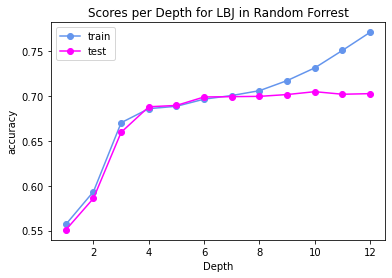

The best model has the Depth Range =  10
Took  33.3  Seconds to Run


In [107]:
#Import Random Forrest
from sklearn.ensemble import RandomForestClassifier
#Set time
start=time.time()

#Set range
depth_range = range(1, 13)
#Empty list
rforest_test_scores = []
rforest_train_scores = []

#Create loop
for n in tqdm(depth_range):
    my_random_forest = RandomForestClassifier(n_estimators=200,max_depth=n)
    my_random_forest.fit(X_train, y_train)
    rforest_test_scores.append(my_random_forest.score(X_test,y_test))
    rforest_train_scores.append(my_random_forest.score(X_train,y_train))

# plot the results
plt.figure()
plt.plot(depth_range,rforest_train_scores, c='cornflowerblue', label='train', marker="o")
plt.plot(depth_range,rforest_test_scores, c='fuchsia', label='test', marker="o")
plt.title('Scores per Depth for LBJ in Random Forrest')
plt.xlabel('Depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#Catch the ArgMax
which_max = np.array(rforest_test_scores).argmax()


print("The best model has the Depth Range = ",depth_range[which_max])

end = time.time()
print("Took ",round((end - start),1)," Seconds to Run")

Max depth at 10 is the best score

In [108]:
my_random_forest = RandomForestClassifier(n_estimators=200,max_depth=depth_range[which_max])
my_random_forest.fit(X_train, y_train)
print(f'Train Score for Random Forrest = {round(my_random_forest.score(X_train, y_train),3)}')
print(f'Test Score for Random Forrest = {round(my_random_forest.score(X_test, y_test),3)}')


Train Score for Random Forrest = 0.733
Test Score for Random Forrest = 0.703


### Boosting

100%|██████████| 10/10 [17:33<00:00, 105.34s/it]


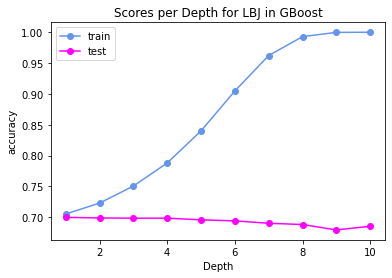

The best model has the Depth Range =  1
Took  1053.7  Seconds to Run


In [109]:
#Import Boost
from sklearn.ensemble import GradientBoostingClassifier
start=time.time()


# Create lists to hold our accuracies
train_accs = []
test_accs = []

depth_range = range(1, 11)

for d in tqdm(depth_range):
    
    # instantiate a tree & fit it
    GB_model = GradientBoostingClassifier(n_estimators=200,max_depth=d)
    GB_model.fit(X_train, y_train)
    
    # evaluate on train & test sets
    train_accs.append(GB_model.score(X_train, y_train))
    test_accs.append(GB_model.score(X_test, y_test))

# plot the results
plt.figure()
plt.plot(depth_range,train_accs, c='cornflowerblue', label='train', marker="o")
plt.plot(depth_range,test_accs, c='fuchsia', label='test', marker="o")
plt.title('Scores per Depth for LBJ in GBoost')
plt.xlabel('Depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#Catch the ArgMax
which_max = np.array(test_accs).argmax()


print("The best model has the Depth Range = ",depth_range[which_max])

end = time.time()
print("Took ",round((end - start),1)," Seconds to Run")

At Max Depth 1 the model preforms the best. 

In [110]:
  # instantiate a tree & fit it
GB_model = GradientBoostingClassifier(n_estimators=100,max_depth=depth_range[which_max])
GB_model.fit(X_train, y_train)

# evaluate on train & test sets
print(f'Train Score for GB Model = {round(GB_model.score(X_train, y_train),3)}')
print(f'Test Score for GB Model = {round(GB_model.score(X_test, y_test),3)}')


Train Score for GB Model = 0.704
Test Score for GB Model = 0.7


### Multinomial Bayes

100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


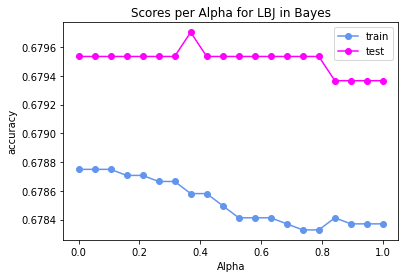

The best model has the Depth Range =  0.37
Took  3.3  Seconds to Run


In [113]:
from sklearn.naive_bayes import MultinomialNB
train_accs = []
test_accs = []

start =time.time()

NBrange = np.linspace(0.0001,1,20)

for d in tqdm(NBrange):
    
    # Instatiate our model
    nbmodel = MultinomialNB(alpha=d)
    # Fit our model
    nbmodel.fit(X_train, y_train)

    # evaluate on train & test sets
    train_accs.append(nbmodel.score(X_train, y_train))
    test_accs.append(nbmodel.score(X_test, y_test))

# plot the results
plt.figure()
plt.plot(NBrange,train_accs, c='cornflowerblue', label='train', marker="o")
plt.plot(NBrange,test_accs, c='fuchsia', label='test', marker="o")
plt.title('Scores per Alpha for LBJ in Bayes')
plt.xlabel('Alpha')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#Catch the ArgMax
which_max = np.array(test_accs).argmax()


print("The best model has the Depth Range = ",round(NBrange[which_max],2))

end = time.time()
print("Took ",round((end - start),1)," Seconds to Run")


Lets evaluate the Logistical Regression model as we saw some of the best results there.

In [116]:
from sklearn.metrics import confusion_matrix
#call the prediction
y_pred = log_reg.predict(X_test)

#  get the confision matrix
confusion_matrix(y_test, y_pred)

array([[  10,    0,    0,    0,    0,    0],
       [   0, 2824,  345,   64,   22,   12],
       [   0,    9,  652,   71,   54,   11],
       [   0,   51,  117,  500,   34,   48],
       [   0,   12,  451,   62,   57,   17],
       [   0,   41,   80,  244,   34,  110]])

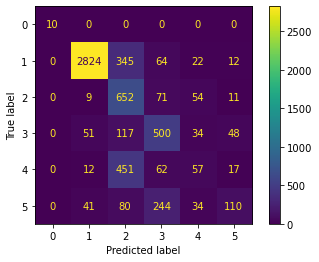

In [117]:
from sklearn.metrics import ConfusionMatrixDisplay

#lets get the the display going
cf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

This does not look good, it seems that the model is predicting most of the shots for 2 and 3 for 4 and 5. Lets see this closer

In [118]:
from sklearn.metrics import classification_report
# Pull the classification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

precision    recall  f1-score   support

       Back Court(BC)       1.00      1.00      1.00        10
            Center(C)       0.96      0.86      0.91      3267
 Left Side Center(LC)       0.40      0.82      0.53       797
         Left Side(L)       0.53      0.67      0.59       750
Right Side Center(RC)       0.28      0.10      0.14       599
        Right Side(R)       0.56      0.22      0.31       509

             accuracy                           0.70      5932
            macro avg       0.62      0.61      0.58      5932
         weighted avg       0.73      0.70      0.69      5932



#### Woah, these numbers are HORRIBLE. The right side center has a recall of .10... <b>thats worse than guessing <b>
<br> The supports of these numbers also seem to favour the left side meaning that the model will just predict the side where the player has historically shot before 

In [51]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

SyntaxError: invalid syntax (<ipython-input-51-bc789509615f>, line 4)

In [120]:
#Lets double check the normalized values
idk['Shot Zone Area'].value_counts(normalize=True)

Center(C)                0.555601
Left Side Center(LC)     0.133859
Left Side(L)             0.118686
Right Side Center(RC)    0.101828
Right Side(R)            0.088273
Back Court(BC)           0.001753
Name: Shot Zone Area, dtype: float64

Still Extreamly poor..lets try some more preproccesing to see if we can fix this

In [114]:
# Instatiate our model
nbmodel = MultinomialNB(alpha=NBrange[which_max])
# Fit our model
nbmodel.fit(X_train, y_train)

# evaluate on train & test sets
print(f'Train Score for NB Bayes = {round(nbmodel.score(X_train, y_train),3)}')
print(f'Test Score for NB Bayes = {round(nbmodel.score(X_test, y_test),3)}')

Train Score for NB Bayes = 0.679
Test Score for NB Bayes = 0.68


## PCA, Cross Validation and rolling up the Classes

So far we have done very rough models. Now, we will have to start fixing certain points in our model. 

In [183]:
#Rebuild the DF
idka=pd.get_dummies(DT_df['Action Type'])
idkb=pd.get_dummies(DT_df['Shot Type'])
idkc=pd.get_dummies(DT_df['Shot Zone Basic'])
idkd=pd.get_dummies(DT_df['Shot Zone Range'])
idk = pd.concat([DT_df, idka, idkb, idkc, idkd], axis=1, sort=False)
idk=idk.drop(['Action Type', 'Shot Type', 'Shot Zone Basic', 'Shot Zone Range'],axis=1)
idk.head(3)

,Game ID,Player ID,Team ID,Period,Minutes Remaining,Seconds Remaining,Shot Zone Area,Shot Distance,Shot Made Flag,Game Date,...,In The Paint (Non-RA),Left Corner 3,Mid-Range,Restricted Area,Right Corner 3,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1194060,20300014,2544,1610612739,1,8,56,Right Side(R),15,1,20031029,...,0,0,1,0,0,0,0,1,0,0
1194061,20300014,2544,1610612739,1,7,44,Left Side(L),13,1,20031029,...,0,0,1,0,0,0,0,1,0,0
1194062,20300014,2544,1610612739,1,7,1,Right Side(R),16,1,20031029,...,0,0,1,0,0,1,0,0,0,0


Lets drop some rows and roll up the classes

In [184]:
#Wel drop all the back court shots because they just add noise
idk[idk['Shot Zone Area']=='Back Court(BC)'].head(3)

,Game ID,Player ID,Team ID,Period,Minutes Remaining,Seconds Remaining,Shot Zone Area,Shot Distance,Shot Made Flag,Game Date,...,In The Paint (Non-RA),Left Corner 3,Mid-Range,Restricted Area,Right Corner 3,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1194069,20300014,2544,1610612739,1,0,0,Back Court(BC),49,0,20031029,...,0,0,0,0,0,0,0,0,1,0
1194203,20300130,2544,1610612739,2,0,0,Back Court(BC),49,0,20031115,...,0,0,0,0,0,0,0,0,1,0
1194556,20300401,2544,1610612739,3,0,1,Back Court(BC),47,0,20031225,...,0,0,0,0,0,0,0,0,1,0


In [185]:
#Lets drop Back court as there are only 52 shots
idk.drop(idk[idk['Shot Zone Area'] == 'Back Court(BC)'].index,inplace=True)
idk.head(3)


,Game ID,Player ID,Team ID,Period,Minutes Remaining,Seconds Remaining,Shot Zone Area,Shot Distance,Shot Made Flag,Game Date,...,In The Paint (Non-RA),Left Corner 3,Mid-Range,Restricted Area,Right Corner 3,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1194060,20300014,2544,1610612739,1,8,56,Right Side(R),15,1,20031029,...,0,0,1,0,0,0,0,1,0,0
1194061,20300014,2544,1610612739,1,7,44,Left Side(L),13,1,20031029,...,0,0,1,0,0,0,0,1,0,0
1194062,20300014,2544,1610612739,1,7,1,Right Side(R),16,1,20031029,...,0,0,1,0,0,1,0,0,0,0


In [186]:
#Double check
idk['Shot Zone Area'].value_counts()

Center(C)                16478
Left Side Center(LC)      3970
Left Side(L)              3520
Right Side Center(RC)     3020
Right Side(R)             2618
Name: Shot Zone Area, dtype: int64

Now lets roll up the classes. We will be moving right side centre, and left side centre into right side and left side. This will help with <br>
A) Prediction <br>
B) Class imbalance

In [187]:
#Roll up the columns
idk.loc[idk['Shot Zone Area'] == 'Left Side Center(LC)' , ['Shot Zone Area']] = 'Left Side(L)'
idk.loc[idk['Shot Zone Area'] == 'Right Side Center(RC)' , ['Shot Zone Area']] = 'Right Side(R)'

In [188]:
#Check
idk['Shot Zone Area'].value_counts()

Center(C)        16478
Left Side(L)      7490
Right Side(R)     5638
Name: Shot Zone Area, dtype: int64

Now that we have rolled up the class, lets label encode it

In [189]:
#Encoding our target
from sklearn.preprocessing import LabelEncoder

# Instantiate the label encoder
le = LabelEncoder()

# Fit and transform the order priority column
idk['Shot Zone Area']=le.fit_transform(idk['Shot Zone Area'])

In [190]:
#Check
idk['Shot Zone Area'].value_counts()

0    16478
1     7490
2     5638
Name: Shot Zone Area, dtype: int64

In [191]:
#Split first
from sklearn.model_selection import train_test_split
X = idk.drop(['Shot Zone Area'],axis=1)
y = idk['Shot Zone Area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [192]:
#Now lets scale
#Scaler
from sklearn.preprocessing import MinMaxScaler

my_minmax_scaler = MinMaxScaler()

my_minmax_scaler = my_minmax_scaler.fit(X_train)

X_train = my_minmax_scaler.transform(X_train)

X_test = my_minmax_scaler.transform(X_test)



In [193]:
#Now lets use PCA to reduce dimensions
from sklearn.decomposition import PCA

start = time.time()

#we want to explain at least 90% of the variance
my_pca = PCA(n_components=.9)
my_pca.fit(X_train)

# transform data
X_train_PCA = my_pca.transform(X_train)

# Transform test data
X_test_PCA = my_pca.transform(X_test)

#print the time
end = time.time()
print(end - start)

0.24938297271728516


In [194]:
#Lets check the shape
X_train_PCA.shape

(23684, 15)

Wow it seems a lot of information comes from a few dimentions. 

In [178]:
#Check the shape
X_test_PCA.shape

(5932, 15)

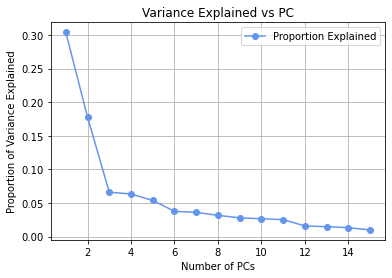

In [195]:
#Setting up the explained variance
expl_var = my_pca.explained_variance_ratio_
#Setting up the plot
plt.figure()
plt.plot(range(1,16,1),expl_var,color='cornflowerblue',label='Proportion Explained',marker='o')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.legend()
plt.title('Variance Explained vs PC')
plt.grid()
plt.show()

## Lets start Modeling with this new data

Lets now model the data but also do cross validation, we will not bother trying the models that did poorly such as SVM. And we will just run Random Forests instead of Dececision trees. 

### Log Reg

In [143]:
from sklearn.model_selection import cross_val_score
start=time.time()
### 5-fold cross validation
cross_validation_scores = []
# The C_values to try
C_values = [.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]

#Do some cross validation
for c in tqdm(C_values):
    #fit the log model
    LR_model = LogisticRegression(C=c,max_iter=100)
    #set the cross validation
    cv_score = np.mean(cross_val_score(LR_model, X_train_PCA, y_train, cv = 5))
    #gather the scores for validation
    cross_validation_scores.append(cv_score)

end = time.time()

print("\n Took ",round((end - start),1)," Seconds to Run")

100%|██████████| 9/9 [00:12<00:00,  1.35s/it]
 Took  12.2  Seconds to Run



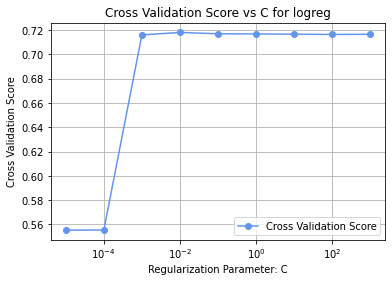

The best model has C =  0.01


In [144]:
# Plot

plt.figure()
plt.plot(C_values, cross_validation_scores,c='cornflowerblue',label="Cross Validation Score",marker='o')
plt.legend()
plt.title('Cross Validation Score vs C for logreg')
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')

plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_values[which_max])


This looks promising, the scores have been raised and we increased the amount of preprocessing.

In [145]:
# Lets print the score of the highest 
# Instantiate the model
log_reg = LogisticRegression(C=C_values[which_max],max_iter=100)

# Fit the model 
log_reg.fit(X_train_PCA,y_train)

# evaluate on train & test sets
print(f'Train Score for Logistical Regression = {round(log_reg.score(X_train_PCA, y_train),3)}')
print(f'Test Score for Logistical Regression = {round(log_reg.score(X_test_PCA, y_test),3)}')

Train Score for Logistical Regression = 0.718
Test Score for Logistical Regression = 0.736


In [147]:
top=pd.DataFrame(zip(idk.drop(['Shot Zone Area'],axis=1), np.transpose(log_reg.coef_)), columns=['features', 'coef']) 

### Random Forrest

In [148]:
#Lets do random forrest
from sklearn.ensemble import RandomForestClassifier
start=time.time()
depth_range = range(1, 13)
cross_validation_scores = []


for n in tqdm(depth_range):
    my_random_forest = RandomForestClassifier(n_estimators=200,max_depth=n)
    cv_score = np.mean(cross_val_score(my_random_forest, X_train_PCA, y_train, cv = 5))

    cross_validation_scores.append(cv_score)

end = time.time()

print("\n Took ",round((end - start),1)," Seconds to Run")

100%|██████████| 12/12 [04:43<00:00, 23.61s/it]
 Took  283.4  Seconds to Run



This is also good, the best result so far! Looks a little bit over fit however. 

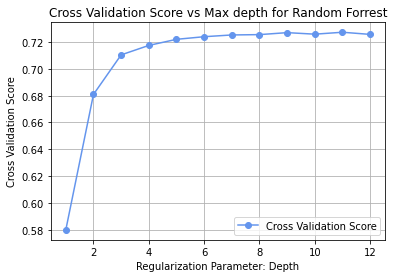

The best model has C =  11


In [149]:
# Plot
plt.figure()
plt.plot(depth_range, cross_validation_scores,c='cornflowerblue',label="Cross Validation Score",marker='o')
plt.legend()
plt.title('Cross Validation Score vs Max depth for Random Forrest')
plt.xlabel('Regularization Parameter: Depth')
plt.ylabel('Cross Validation Score')

plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",depth_range[which_max])

In [150]:
# Instantiate the model
my_random_forest = RandomForestClassifier(n_estimators=200,max_depth=depth_range[which_max])

# Fit the model 
my_random_forest.fit(X_train_PCA,y_train)

# evaluate on train & test sets
print(f'Train Score for Random Forrest = {round(my_random_forest.score(X_train_PCA, y_train),3)}')
print(f'Test Score for Random Forrest= {round(my_random_forest.score(X_test_PCA, y_test),3)}')

Train Score for Random Forrest = 0.81
Test Score for Random Forrest= 0.733


### GBoost

In [151]:
#Lets do GBoost
start=time.time()

depth_range = range(1, 8)
cross_validation_scores = []


for n in tqdm(depth_range):
    GB_model = GradientBoostingClassifier(max_depth=n)
    cv_score = np.mean(cross_val_score(GB_model, X_train_PCA, y_train, cv = 5))

    cross_validation_scores.append(cv_score)


end = time.time()

print("\n Took ",round((end - start),1)," Seconds to Run")

100%|██████████| 7/7 [20:17<00:00, 173.99s/it]
 Took  1218.0  Seconds to Run



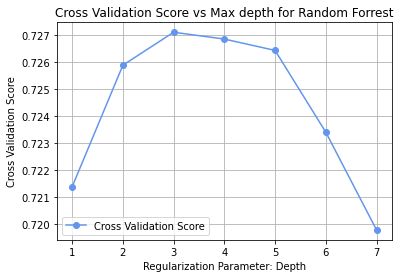

The best model has the best Depth =  3


In [152]:
# Plot
plt.figure()
plt.plot(depth_range, cross_validation_scores,c='cornflowerblue',label="Cross Validation Score",marker='o')
plt.legend()
plt.title('Cross Validation Score vs Max depth for Random Forrest')
plt.xlabel('Regularization Parameter: Depth')
plt.ylabel('Cross Validation Score')

plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has the best Depth = ",depth_range[which_max])

In [153]:
# Instantiate the model
GB_model = GradientBoostingClassifier(max_depth=depth_range[which_max])

# Fit the model 
GB_model.fit(X_train_PCA,y_train)

# evaluate on train & test sets
print(f'Train Score for Random Forrest = {round(GB_model.score(X_train_PCA, y_train),3)}')
print(f'Test Score for Random Forrest= {round(GB_model.score(X_test_PCA, y_test),3)}')

Train Score for Random Forrest = 0.755
Test Score for Random Forrest= 0.741


## Bayes

In [218]:
#Lets do Bayes
start=time.time()

NBrange = np.linspace(0.01,1,10)
cross_validation_scores = []
for d in tqdm(NBrange):
    
    # Instatiate our model
    nbmodel = MultinomialNB(alpha=d)
    # Fit our model
    cv_score = np.mean(cross_val_score(nbmodel, X_train, y_train, cv = 5))

    cross_validation_scores.append(cv_score)

end=time.time()

print("\n Took ",round((end - start),1)," Seconds to Run")

100%|██████████| 10/10 [00:00<00:00, 10.22it/s]
 Took  1.0  Seconds to Run



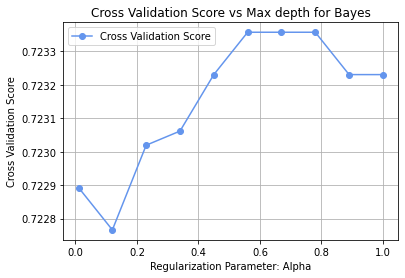

The best model has Alpha =  0.67


In [219]:
# Plot
plt.figure()
plt.plot(NBrange, cross_validation_scores,c='cornflowerblue',label="Cross Validation Score",marker='o')
plt.legend()
plt.title('Cross Validation Score vs Max depth for Bayes')
plt.xlabel('Regularization Parameter: Alpha')
plt.ylabel('Cross Validation Score')

plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has Alpha = ",NBrange[which_max])

In [220]:
nbmodel = MultinomialNB(alpha=NBrange[which_max])
# Fit our model
nbmodel.fit(X_train, y_train)

print(f'Train Score for Bayes = {round(nbmodel.score(X_train, y_train),3)}')
print(f'Test Score for Bayes = {round(nbmodel.score(X_test, y_test),3)}')

Train Score for Bayes = 0.724
Test Score for Bayes = 0.739


### Now lets evaluate the model as well. Since GBoost did the best lets predict that.

In [225]:
#Call the confusion Matrix
from sklearn.metrics import confusion_matrix

y_pred = log_reg.predict(X_test_PCA)

# True values first, predicted values second
confusion_matrix(y_test, y_pred)

array([[2891,  405,   29],
       [  56, 1341,  136],
       [  41,  896,  127]])

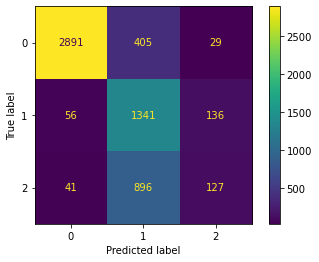

In [230]:
#Lets get a nice display
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [227]:
#Look at the normalized values
idk['Shot Zone Area'].value_counts(normalize=True)

0    0.556576
1    0.252989
2    0.190434
Name: Shot Zone Area, dtype: float64

In [231]:
#Lets get the classification report
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

precision    recall  f1-score   support

           0       0.97      0.87      0.92      3325
           1       0.51      0.87      0.64      1533
           2       0.43      0.12      0.19      1064

    accuracy                           0.74      5922
   macro avg       0.64      0.62      0.58      5922
weighted avg       0.75      0.74      0.71      5922



We are still suffering from the same problems. The recall score for 2 is 12% meaning that the model is literally worse than guessing for right side shots. We will need to further model and try different steps.We are still suffering from the same problems.

# Please go to the next NoteBook -> Further Modeling# Please go to the next NoteBook -> Further Modeling